<a href="https://colab.research.google.com/github/rkongcheep/pythonTradingBot/blob/main/AlgoTrading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade pandas-datareader

!pip install --upgrade pandas

     |████████████████████████████████| 109 kB 8.2 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


# 0 - Setup and Load Data

In [ ]:
import pandas as pd
from pandas_datareader import data as pdr

def load_financial_data(symbol,start_date,end_date,output_file):
  try:
    df = pd.read_pickle(output_file)
    print('File Exist . . Reading Data')
  except:
    print(f'File Not Found . . downloading {symbol} data')
    df = pdr.DataReader(symbol,'yahoo',start_date,end_date)
    df.to_pickle(f'{output_file}')
  return df


goog_data = load_financial_data('GOOG','2020-04-30','2022-04-30','GOOG_data.pkl')


File Not Found . . downloading GOOG data


# 1 - Create Technical Indicators

6 Main Technical Indicator:
1. OBV
2. MACD
3. RSI
4. 5 days Momentum
5. Accumulation/Distribution

In [ ]:
import numpy as np
## 1. OBV
def cal_OBV(df):
  OBV_data = pd.DataFrame(index = df.index)

  data_signal = pd.DataFrame(index = df.index)
  data_signal['Close'] = df['Close']
  data_signal['Close_diff'] = df['Close'].diff() ## Today - Yesterday
  data_signal['Volume'] = df['Volume']
  data_signal['OBV'] = np.where(data_signal['Close_diff']>0,
                                data_signal['Volume'],
                                np.where(data_signal['Close_diff'].fillna(0)==0,0,-data_signal['Volume'])).cumsum()
  data_signal['OBV_ema'] = data_signal['OBV'].ewm(com=5).mean()
  df['OBV'] = data_signal['OBV']
  df['OBV_ema'] = data_signal['OBV_ema']
  OBV_lower = pd.DataFrame({'signal':np.where(df['OBV']<df['OBV_ema'],-1,0)},index=df.index)
  tmp_diff = pd.DataFrame(OBV_lower.diff().fillna(0))
  # Buy_idx = tmp_diff['signal'] == 1.0
  # Sell_idx = tmp_diff['signal'] == -1.0 

  # Buy_idx = Buy_idx.astype(bool)
  # Sell_idx = Sell_idx.astype(bool)
  df['OBV_signal'] = tmp_diff
  # df['OBV_sell_signal'] = Sell_idx
  return df   

## 2. MACD
def cal_MACD(df):
  df['st_ema'] = df['Adj Close'].ewm(span=12).mean()
  df['lt_ema'] = df['Adj Close'].ewm(span=26).mean()
  df['MACD'] = df['st_ema'] - df['lt_ema']
  df['MACD_ema'] = df['MACD'].ewm(span=9).mean()

  n = len(df)
  signal_idx = np.zeros(n)
  Sell_idx = np.zeros(n)
  for t in range(1,n):
    if (df['MACD'][t-1] < df['MACD_ema'][t-1] and df['MACD'][t] >= df['MACD_ema'][t]):
      signal_idx[t]=1
    if (df['MACD'][t-1] >= df['MACD_ema'][t-1] and df['MACD'][t]<df['MACD_ema'][t]):
      signal_idx[t]=-1
  # Buy_idx = Buy_idx.astype(bool)
  # Sell_idx = Sell_idx.astype(bool)
  df['MACD_signal'] = signal_idx
  # df['MACD_sell_signal'] = Sell_idx
  return df

## 3. RSI
def cal_RSI(df):
  df['diff'] = df['Adj Close'].diff()
  df['gain'] = np.where(df['diff']<=0,0,df['diff'])
  df['loss'] = np.where(df['diff']>0,0,-df['diff'])
  df['avg_gain'] = df['gain']
  df['avg_gain'][14] = df['avg_gain'][1:15].mean()
  df['avg_gain'][1:14] = np.nan
  df['avg_gain'] = df['avg_gain'].ewm(adjust=False,alpha=1/14).mean()
  
  df['avg_loss'] = df['loss']
  df['avg_loss'][14] = df['avg_loss'][1:15].mean()
  df['avg_loss'][1:14] = np.nan
  df['avg_loss'] = df['avg_loss'].ewm(adjust=False,alpha=1/14).mean()

  df['RSI'] = 100-100/(1+df['avg_gain']/df['avg_loss'])
  df['RSI_signal'] = np.where(df['RSI']<30,1
                              ,np.where(df['RSI']>70,-1
                                        ,0))

  return df

## 4. Momentum
def cal_MOM(df):
  df['MOM'] = df['Adj Close'].pct_change(20)

## 5. AD (Accumulation Distribution)
def cal_AD(df):
  df['AD'] = 0
  for index,row in df.iterrows():
    if row.High != row.Low:
      ac = ((((row.Close - row.Low) - (row.High - row.Close))/(row.High-row.Low))*row.Volume)
      df.loc[index,'AD'] = ac
  return df

def cal_all_indicator(df):
  cal_OBV(df)
  cal_MACD(df)
  cal_RSI(df)
  cal_MOM(df)
  cal_AD(df)
  return

File Not Found . . downloading TTB.BK data


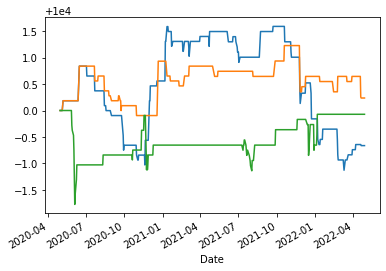

In [ ]:
def signal_test(df,ind='MACD'):
  init_amount = 10000

  signal = pd.DataFrame(index = df.index)
  positions = pd.DataFrame(index = df.index)
  portfolio = pd.DataFrame(index = df.index)

  holding_stock = False
  cost = 0.0
  revenue = 0.0
  n = len(df)
  for i in range(n):
    if df[f'{ind}_signal'][i]==1.0:
      if holding_stock == True:
        continue
      cost += df['Adj Close'][i]
      holding_stock = True

    if df[f'{ind}_signal'][i]==-1.0:
      if holding_stock == False:
        continue
      revenue += df['Adj Close'][i]
      holding_stock = False

  positions['stock'] = df[f'{ind}_signal'] * 10
  portfolio['holdings'] = df[f'{ind}_signal'] * df['Adj Close'] * 10 

  pos_diff = positions['stock'].diff().fillna(0)
  cash_change = - pos_diff * df['Adj Close']
  portfolio['cash'] = init_amount + cash_change.cumsum()
  portfolio['total'] = portfolio['cash'] + portfolio['holdings']
  portfolio['returns'] = portfolio['total'].pct_change()

  return portfolio

symbol = 'TTB.BK'
start_date = '2020-04-30'
end_date = '2022-04-30'
filename = f'{symbol}_data.pkl'

data_df = load_financial_data(symbol,start_date,end_date,filename)
cal_OBV(data_df)
cal_MACD(data_df)
cal_RSI(data_df)
OBV_port = signal_test(data_df,ind='OBV')
MACD_port = signal_test(data_df,ind='MACD')
RSI_port = signal_test(data_df,ind='RSI')

OBV_port.total.plot()
MACD_port.total.plot()
RSI_port.total.plot()


# 2 - ML with Technical Indicator

## 2.1 Create Trading Condition

In [ ]:
from pandas.io.formats.info import DataFrameTableBuilderNonVerbose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn import svm

x_list = ['Open-Close','High-Low','OBV','MACD','RSI','MOM','AD']

def create_classification_trading_condition(df):
  df['Classification Target'] = np.where(df['Close'].shift(-1)>df['Close'],1,-1)
  df['Open-Close'] = df['Open'] - df['Close']
  df['High-Low'] = df['High'] - df['Low']
  cal_all_indicator(df)
  df = df.dropna()
  X = df[x_list]
  Y = df[['Classification Target']]
  return (df,X,Y)

def create_regression_trading_condition(df):
  df['Regression Target'] = df['Close'].diff(-1)
  df['Open-Close'] = df['Open'] - df['Close']
  df['High-Low'] = df['High'] - df['Low']
  cal_all_indicator(df)
  df = df.dropna()
  X = df[x_list]
  Y = df[['Regression Target']]
  return (df,X,Y)

def create_train_split_group(X,Y,split_ratio = 0.8):
  return train_test_split(X,Y,shuffle=False,train_size=split_ratio)

## 2.2 Gen ML Prediction

In [ ]:
from pandas._libs.tslibs.period import DIFFERENT_FREQ
method_list = ['Reg','Lasso','Ridge','PCA_KNN','LDA_KNN','SVM','NN']

def cal_Reg(df_):
  np.random.seed(1)
  df,X,Y = create_regression_trading_condition(df_)
  X_train,X_test,Y_train,Y_test = create_train_split_group(X,Y)
  ols = LinearRegression()
  df['Reg_pred_return'] = ols.fit(X_train,Y_train).predict(X)
  return df

def cal_Lasso(df_):
  np.random.seed(1)
  df,X,Y = create_regression_trading_condition(df_)
  X_train,X_test,Y_train,Y_test = create_train_split_group(X,Y)
  lasso = Lasso(alpha=0.1)
  df['Lasso_pred_return'] = lasso.fit(X_train,Y_train).predict(X)
  return df

def cal_Ridge(df_):
  np.random.seed(1)
  df,X,Y = create_regression_trading_condition(df_)
  X_train,X_test,Y_train,Y_test = create_train_split_group(X,Y)
  ridge = Ridge()
  df['Ridge_pred_return'] = ridge.fit(X_train,Y_train).predict(X)
  return df

## Classification Based
def cal_PCA_KNN(df_):
  np.random.seed(1)
  df,X,Y = create_classification_trading_condition(df_)
  X = StandardScaler().fit_transform(X)
  X_train, X_test, Y_train, Y_test = create_train_split_group(X, Y, split_ratio=0.8)
  pca = PCA(n_components=0.9).fit(X_train)
  X_train_pca, X_test_pca,X_pca = pca.transform(X_train), pca.transform(X_test), pca.transform(X)
  df['PCA_KNN_pred_return'] = KNeighborsClassifier().fit(X_train_pca, Y_train).predict(X_pca)
  return df#nn, X_train_pca, Y_train, X_test_pca, Y_test

## Classification Based
def cal_LDA_KNN(df_):
  np.random.seed(1)
  df,X,Y = create_classification_trading_condition(df_)
  X = StandardScaler().fit_transform(X)
  X_train, X_test, Y_train, Y_test = create_train_split_group(X, Y, split_ratio=0.8)
  lda = LinearDiscriminantAnalysis().fit(X_train, Y_train)
  X_train = lda.transform(X_train)
  X_test = lda.transform(X_test)
  X_lda = lda.transform(X)
  df['LDA_KNN_pred_return'] = KNeighborsClassifier().fit(X_train, Y_train).predict(X_lda)
  return df #nn, X_train, Y_train, X_test, Y_test

def cal_SVM(df_):
    # use SVM.SVC() in sklearn to fit the data
    # use the default setting
    np.random.seed(1)
    df,X,Y = create_classification_trading_condition(df_)
    X = StandardScaler().fit_transform(X)
    X_train, X_test, Y_train, Y_test = create_train_split_group(X, Y, split_ratio=0.8)
    clf = svm.SVC()
    clf.fit(X_train, Y_train) 
    df['SVM_pred_return'] = clf.predict(X)
    return df

def cal_NN(df_):
    # use MLPClassifier in sklearn to fit the data
    # set your solver as 'lbfgs', alpha=1e-5, 1 hidden layer with 8 nodes, random_state=1
    np.random.seed(1)
    df,X,Y = create_classification_trading_condition(df_)
    X = StandardScaler().fit_transform(X)
    X_train, X_test, Y_train, Y_test = create_train_split_group(X, Y, split_ratio=0.8)
    clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=8, random_state=1)
    clf.fit(X_train, Y_train) 
    df['NN_pred_return'] = clf.predict(X)
    return df


## 2.3 Naive Backtest Function

In [ ]:
## Test Regression Strategy
def calculate_return(df,split_value,method):
  df['real_return'] = np.log(df['Close']/df['Close'].shift(1))
  cum_return = df[split_value:]['real_return'].cumsum()*100
  cum_strategy_return = (df['real_return'] * df[f'{method}_pred_return'].shift(1) )[split_value:].cumsum()*10000
  return cum_return,cum_strategy_return

def calculate_return2(df,split_value,method):
  df['real_return'] = np.log(df['Close']/df['Close'].shift(1))
  cum_return = df[split_value:]['real_return'].cumsum()*100
  cum_strategy_return = (df['real_return'] * df[f'{method}_pred_return'].shift(1) )[split_value:].cumsum()*100
  return cum_return,cum_strategy_return



In [ ]:
pd.options.mode.chained_assignment = None
symbol = 'TTB.BK'
start_date = '2020-04-30'
end_date = '2022-04-30'
filename = f'{symbol}_data.pkl'
method_list = ['Reg','Lasso','Ridge','PCA_KNN','LDA_KNN','SVM','NN']
data_df2 = load_financial_data(symbol,start_date,end_date,filename)
data_df2 = cal_Reg(data_df2)
data_df2 = cal_Ridge(data_df2)
data_df2 = cal_Lasso(data_df2)
data_df2 = cal_PCA_KNN(data_df2)
data_df2 = cal_LDA_KNN(data_df2)
data_df2 = cal_SVM(data_df2)
data_df2 = cal_NN(data_df2)
data_df2.head()

File Exist . . Reading Data


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=6.78333e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fi

,High,Low,Open,Close,Volume,Adj Close,Regression Target,Open-Close,High-Low,OBV,...,MOM,AD,Reg_pred_return,Ridge_pred_return,Lasso_pred_return,Classification Target,PCA_KNN_pred_return,LDA_KNN_pred_return,SVM_pred_return,NN_pred_return
Date,,,,,,,,,,,,,,,,,,,,,
2020-11-30,1.11,1.05,1.11,1.05,0.000000e+00,0.981429,-0.03,0.06,0.06,2.627548e+09,...,0.280488,-0.000000e+00,-0.003134,-0.003892,-0.001484,1,-1,-1,1,1
2020-12-01,1.11,1.08,1.08,1.08,1.196707e+09,1.009469,-0.03,0.00,0.03,3.824255e+09,...,0.285714,-1.196707e+09,0.000586,-0.003838,-0.001633,1,1,1,1,1
2020-12-02,1.13,1.08,1.09,1.11,1.139020e+09,1.037510,-0.01,-0.02,0.05,4.963275e+09,...,0.305882,2.278041e+08,0.004247,-0.000881,0.000832,1,-1,-1,-1,1
2020-12-03,1.13,1.09,1.10,1.12,8.420815e+08,1.046857,-0.04,-0.02,0.04,5.805357e+09,...,0.258427,4.210408e+08,0.006136,0.000714,0.001780,1,-1,-1,-1,1
2020-12-04,1.18,1.12,1.13,1.16,1.798805e+09,1.084245,-0.08,-0.03,0.06,7.604162e+09,...,0.260870,5.996018e+08,0.006981,0.002950,0.003567,1,-1,1,-1,1


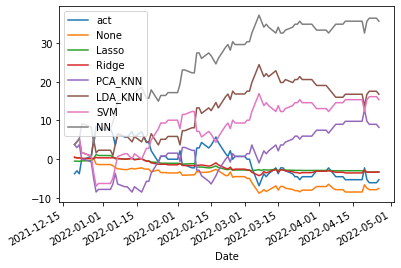

In [ ]:
import matplotlib.pyplot as plt

temo_df = data_df2.copy()
temo_,X,Y = create_regression_trading_condition(temo_df)
X_train,X_test,Y_train,Y_test = create_train_split_group(X,Y)
cum_ret,cum_strat_ret_Reg = calculate_return(data_df2,len(X_train),method = 'Reg')
cum_ret.plot(label = 'act')
cum_strat_ret_Reg.plot()
method_list = ['Reg','Lasso','Ridge','PCA_KNN','LDA_KNN','SVM','NN']
for i in method_list[1:3]:
  cum_ret,cum_strat_ret_ = calculate_return(data_df2,len(X_train),method = i)
  cum_strat_ret_.plot(label=f'{i}')

for i in method_list[3:]:
  cum_ret,cum_strat_ret_ = calculate_return2(data_df2,len(X_train),method = i)
  cum_strat_ret_.plot(label=f'{i}')
  
plt.legend()

# 3 - Algorithmic Trading Strategy


1.   Classic Strategy
*   Dual MA
*   Naive Momentum Strategy
*   Turtle
*   Pair Correlation Trading (Mean reversion)

2.   More Sophisticated
*   APO
*   APO - Mean Reversion
*   APO - Trend Following
*   Statistical Arbitrage










## 3.1 Dual MA

In [ ]:
### 2. Dual MA / Naive Momentum Strategy / Turtle 

# Load Data
pd.options.mode.chained_assignment = None
symbol = 'TTB.BK'
start_date = '2020-04-30'
end_date = '2022-04-30'
filename = f'{symbol}_data.pkl'
data_df3 = load_financial_data(symbol,start_date,end_date,filename)

def cal_dualMA(df,short_window,long_window):
  signals = pd.DataFrame(index = df.index)
  signals['dualMA_signal'] = 0.0
  # df['dualMA_signal'] = 0.0
  signals['short_mavg'] = df['Close'].rolling(window=short_window,min_periods=1,center=False).mean()
  signals['long_mavg'] = df['Close'].rolling(window=long_window,min_periods=1,center=False).mean()
  signals['dualMA_signal'][short_window:] = \
  np.where(signals['short_mavg'][short_window:]>signals['long_mavg'][short_window:],1.0,0.0)
  df['dualMA_signal'] = signals['dualMA_signal'].diff().fillna(0)
  df['dualMA_short_mavg'] = signals['short_mavg']
  df['dualMA_long_mavg'] = signals['long_mavg']
  return df



File Exist . . Reading Data


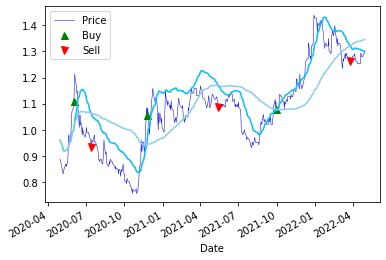

In [ ]:

def plot_signal(df,method):
  df['Adj Close'].plot(color='b',lw=.5)
  plt.plot(df.loc[df[f'{method}_signal']==1.0].index\
           ,df['Adj Close'].loc[df[f'{method}_signal']==1.0]\
           ,'^',markersize=7,color='g')
  plt.plot(df.loc[df[f'{method}_signal']==-1.0].index\
           ,df['Adj Close'].loc[df[f'{method}_signal']==-1.0]\
           ,'v',markersize=7,color='r')
  plt.legend(['Price','Buy','Sell'])


data_df3 = cal_dualMA(data_df3,20,100)
plot_signal(data_df3,'dualMA')
plt.plot(data_df3['dualMA_short_mavg'],color='deepskyblue')
plt.plot(data_df3['dualMA_long_mavg'],color='skyblue')

## 3.2 Naive Momentum

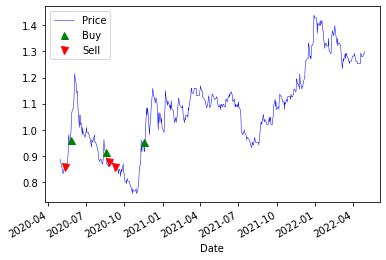

In [ ]:
def cal_naiveMOM(df,nb_conseq_day):
  signals = pd.DataFrame(index = df.index)
  df['naiveMOM_signal'] = 0.0
  cons_day = 0
  prior_price = 0
  init = True
  for idx,row in df.iterrows():
    price = row['Adj Close']
    if init:
      prior_price = price
      init = False
    elif price>prior_price:
      if cons_day<0:
        cons_day = 0
      cons_day +=1
    elif price<prior_price:
      if cons_day>0:
        cons_day=0
      cons_day-=1
    if cons_day==nb_conseq_day:
      df.loc[idx,'naiveMOM_signal']=1.
    elif cons_day==-nb_conseq_day:
      df.loc[idx,'naiveMOM_signal']=-1.
  return df

data_df3 = cal_naiveMOM(data_df3,5)
plot_signal(data_df3,'naiveMOM')

## 3.3 Turtle Strategy

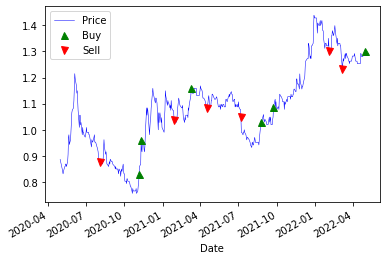

In [ ]:
def cal_Turtle(df,window_size):
  signals = pd.DataFrame(index=df.index)
  df['Turtle_signal'] = 0
  signals['orders'] = 0
  # high window
  signals['high'] = df['Adj Close'].shift(1).rolling(window=window_size).max()
  # low window
  signals['low'] = df['Adj Close'].shift(1).rolling(window=window_size).min()
  signals['avg'] = df['Adj Close'].shift(1).rolling(window = window_size).mean()
  signals['long_entry'] = df['Adj Close'] > signals.high
  signals['short_entry'] = df['Adj Close'] < signals.low
  signals['long_exit'] = df['Adj Close'] < signals.avg
  signals['short_exit'] = df['Adj Close'] > signals.avg
  init = True
  position = 0
  for idx,row in signals.iterrows():
    if row.long_entry and position == 0:
      df.loc[idx,'Turtle_signal'] = 1
      position = 1
    elif row.short_entry and position ==0:
      df.loc[idx,'Turtle_signal'] = -1
      position = -1
    elif row.long_exit and position>0:
      df.loc[idx,'Turtle_signal'] = -1
      position = 0
    elif row.short_exit and position<0:
      df.loc[idx,'Turtle_signal'] = 1
      position = 0

  return df

data_df3 = cal_Turtle(data_df3,50)
plot_signal(data_df3,'Turtle')


## 3.4 Statistical Arbitrage
### 3.4.1 stat arb - 7 pair - BTC,ETH,BNB,XRP,SOL,LUNA,ADA

In [ ]:
pd.options.mode.chained_assignment = None
symbol = 'ADA-USD'
start_date = '2020-04-30'
end_date = '2022-04-30'
filename = f'{symbol}_data.pkl'
#method_list = ['Reg','Lasso','Ridge','PCA_KNN','LDA_KNN','SVM','NN']
btc = load_financial_data(symbol,start_date,end_date,filename)


File Not Found . . downloading ADA-USD data


File Exist . . Reading Data
File Exist . . Reading Data
File Exist . . Reading Data
File Exist . . Reading Data
File Exist . . Reading Data
File Exist . . Reading Data
File Exist . . Reading Data


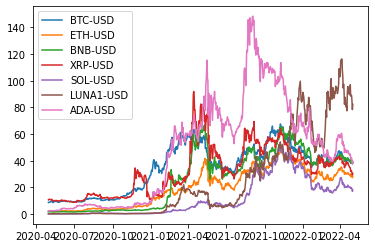

In [ ]:
symbol_list = ['BTC-USD','ETH-USD','BNB-USD','XRP-USD','SOL-USD',\
               'LUNA1-USD','ADA-USD']
start_date = '2020-04-30'
end_date = '2022-04-30'
symbols_data = {}
for symbol_i in symbol_list:
  filename = f'{symbol_i}_data.pkl'
  symbols_data[symbol_i] = load_financial_data(symbol_i,start_date,end_date,filename)

TRADING_INSTRUMENT = 'BTC-USD'
scaler_list = [1000,100,10,1/50,5,1,1/50]
for s_i,i in enumerate(symbol_list):
  scaler_list = [1000,100,10,1/50,5,1,1/50]
  scaler = 1/scaler_list[s_i]
  plt.plot(symbols_data[i].Close*scaler,label=f'{i}')
  plt.legend()



### 3.4.2 Defining StatArb signal parameters

In [ ]:
import statistics as stats

SMA_NUM_PERIODS = 20
price_history = {}

PRICE_DEV_NUM_PRICES = 200
price_deviation_from_sma = {}

num_days = len(symbols_data[TRADING_INSTRUMENT])
correlation_history = {}
delta_projected_actual_history = {}

final_delta_projected_history = []

orders = []
positions = []
pnls = []

last_buy_price = 0
last_sell_price = 0
position = 0
buy_sum_price_qty = 0
buy_sum_qty = 0
sell_sum_price_qty = 0
sell_sum_qty = 0
open_pnl = 0
closed_pnl = 0

StatArb_VALUE_FOR_BUY_ENTRY = 0.01
StatArb_VALUE_FOR_SELL_ENTRY = -0.01
MIN_PRICE_MOVE_FROM_LAST_TRADE = 0.01
NUM_SHARES_PER_TRADE = 50

MIN_PROFIT_TO_CLOSE = 10

for i in range(num_days):
  close_prices = {}
  for symbol in symbol_list:
    close_prices[symbol] = symbols_data[symbol].Close.iloc[i]

    if not symbol in price_history.keys():
      price_history[symbol] = []
      price_deviation_from_sma[symbol] = []

    price_history[symbol].append(close_prices[symbol])

    if len(price_history[symbol]) > SMA_NUM_PERIODS:
      del (price_history[symbol][0])
    sma = np.mean(price_history[symbol])
    price_deviation_from_sma[symbol].append(close_prices[symbol]-sma)
    if len(price_deviation_from_sma[symbol])>PRICE_DEV_NUM_PRICES:
      del(price_deviation_from_sma[symbol][0])

  projected_dev_from_sma_using = {}
  for symbol in symbol_list:
    if symbol == TRADING_INSTRUMENT:
      continue
    correlation_label = TRADING_INSTRUMENT + '&' + symbol
    if correlation_label not in correlation_history.keys():
      correlation_history[correlation_label] = []
      delta_projected_actual_history[correlation_label] = []
    if len(price_deviation_from_sma[symbol])<2:
      correlation_history[correlation_label].append(0)
      delta_projected_actual_history[correlation_label].append(0)
      continue
    corr = np.corrcoef(price_deviation_from_sma[TRADING_INSTRUMENT],price_deviation_from_sma[symbol])
    cov = np.cov(price_deviation_from_sma[TRADING_INSTRUMENT],price_deviation_from_sma[symbol])
    corr_trading_instrument_lead_instrument = corr[0,1]
    cov_trading_instrument_lead_instrument = cov[0,0]/cov[0,1]
    correlation_history[correlation_label].append(corr_trading_instrument_lead_instrument)

    projected_dev_from_sma_using[symbol] = price_deviation_from_sma[symbol][-1]*cov_trading_instrument_lead_instrument

    delta_projected_actual = (projected_dev_from_sma_using[symbol] - price_deviation_from_sma[TRADING_INSTRUMENT][-1])
    delta_projected_actual_history[correlation_label].append(delta_projected_actual)

  sum_weights = 0
  for symbol in symbol_list:
    if symbol == TRADING_INSTRUMENT:
      continue
    
    correlation_label = TRADING_INSTRUMENT + '&' + symbol
    sum_weights += abs(correlation_history[correlation_label][-1])
  
  final_delta_projected = 0
  close_prices = close_prices[TRADING_INSTRUMENT]

  for symbol in symbol_list:
    if symbol == TRADING_INSTRUMENT:
      continue
    correlation_label = TRADING_INSTRUMENT + '&' + symbol
    final_delta_projected += abs(correlation_history[correlation_label][-1])\
    * delta_projected_actual_history[correlation_label][-1]

  if sum_weights != 0:
    final_delta_projected /= sum_weights
  else:
    final_delta_projected = 0
  final_delta_projected_history.append(final_delta_projected)

  if ((final_delta_projected<StatArb_VALUE_FOR_SELL_ENTRY and abs(close_prices - last_sell_price)>MIN_PRICE_MOVE_FROM_LAST_TRADE) \
      or (position > 0 and (open_pnl > MIN_PROFIT_TO_CLOSE))):
    orders.append(-1)
    last_sell_price = close_prices
    position -= NUM_SHARES_PER_TRADE
    sell_sum_price_qty += (close_prices*NUM_SHARES_PER_TRADE)
    sell_sum_qty += NUM_SHARES_PER_TRADE
  elif ((final_delta_projected>StatArb_VALUE_FOR_BUY_ENTRY and abs(close_prices-last_buy_price)>MIN_PRICE_MOVE_FROM_LAST_TRADE) or\
        (position < 0 and (open_pnl>MIN_PROFIT_TO_CLOSE))):
    orders.append(1)
    last_buy_price = close_prices
    position += NUM_SHARES_PER_TRADE
    buy_sum_price_qty += (close_prices*NUM_SHARES_PER_TRADE)
    buy_sum_qty += NUM_SHARES_PER_TRADE
  else:
    orders.append(0)
  
  open_pnl = 0
  if position >0:
    if sell_sum_qty>0:
      open_pnl = abs(sell_sum_qty) * (sell_sum_price_qty/sell_sum_qty -\
                                      buy_sum_price_qty/buy_sum_qty)
    open_pnl += abs(sell_sum_qty - position) * (close_prices - buy_sum_price_qty/buy_sum_qty)
  elif position < 0 :
    if buy_sum_qty>0:
      open_pnl = abs(buy_sum_qty) * (sell_sum_price_qty/sell_sum_qty - buy_sum_price_qty/buy_sum_qty)
    open_pnl+= abs(buy_sum_qty-position) * (sell_sum_price_qty/sell_sum_qty-close_prices)

  else:
    closed_pnl += (sell_sum_price_qty - buy_sum_price_qty)
    buy_sum_price_qty = 0
    buy_sum_qty = 0
    sell_sum_price_qty = 0
    sell_sum_qty = 0
    last_buy_price = 0
    last_sell_price = 0
  pnls.append(closed_pnl+open_pnl)


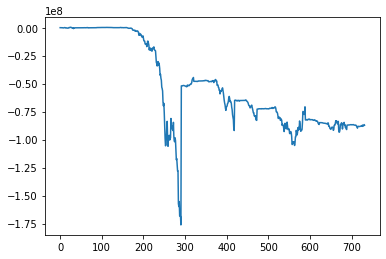

In [ ]:
plt.plot(pnls)

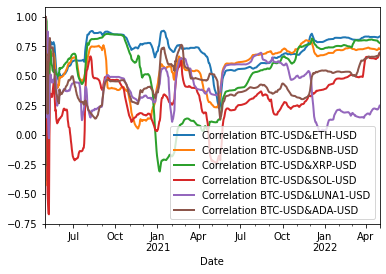

In [ ]:
correlation_data = pd.DataFrame()
for symbol in symbol_list:
  if symbol == TRADING_INSTRUMENT:
    continue
  correlation_label = TRADING_INSTRUMENT + '&' + symbol
  correlation_data = correlation_data.assign(label=pd.Series(correlation_history[correlation_label], index=symbols_data[symbol].index))
  ax = correlation_data['label'].plot(lw=2., label='Correlation ' + correlation_label)

plt.legend()

# 4 - Risk Management System

In [ ]:
### 4. Risk Management System - Using it with 2. and 3. strategy


# 5 - MVO

## 5.1 Tangency Portfolio

In [ ]:
### 5. Session 10 quiz - Review MVO
data = pd.read_excel('multi_asset_returns.xlsx')
data.set_index('Date',inplace=True)

sig = data.cov()
mu = data.mean()

w_tan = (1/(np.ones((1,sig.shape[0]))) @ np.linalg.inv(sig) @ mu) * np.linalg.inv(sig) @ mu
portfolio_returns = data @ w_tan

## 5.2 Allocation with target return

In [ ]:
inv_sig = np.linalg.inv(sig)
delta = ((np.ones((1,sig.shape[0]))))

In [ ]:
sig_d = np.zeros(sig.shape)
np.fill_diagonal(sig_d,sig.to_numpy().diagonal())
sig_d.diagonal()

array([0.00163284, 0.00219749, 0.00321846, 0.00388497, 0.00019756,
       0.00062079, 0.00264792, 0.0027368 , 0.00027163, 0.00046381,
       0.00016779])

# 6 - Performance Evaluation

In [ ]:
### 6. Performance Evaluation
## Linear Regression

# 7 - Trading System from Scratch